# 加载MNIST数据

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
# 加载fishion_mnist
(train_image,train_label),(test_image,test_label) = tf.keras.datasets.mnist.load_data()

In [3]:
train_image = train_image/255
test_image = test_image/255

In [4]:
train_image_resize = np.reshape(train_image,(60000,784))
test_image_resize = np.reshape(test_image,(10000,784))

In [5]:
train_label_onehot = tf.keras.utils.to_categorical(train_label)
test_label_onehot  = tf.keras.utils.to_categorical(test_label)

# Tensorflow 训练神经网络模型

In [6]:
import tensorflow as tf

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30,input_shape=(784,),activation  = 'relu'),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(10,activation='softmax')
    ])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                23550     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
Total params: 24,900
Trainable params: 24,900
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [10]:
history = model.fit(train_image_resize,train_label_onehot,epochs=10,validation_data = (test_image_resize,test_label_onehot))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4605 - acc: 0.8573 - val_loss: 0.1822 - val_acc: 0.9475
Epoch 2/10
1875/1875 [==============================] - 2s 973us/step - loss: 0.1692 - acc: 0.9501 - val_loss: 0.1418 - val_acc: 0.9579
Epoch 3/10
1875/1875 [==============================] - 2s 962us/step - loss: 0.1337 - acc: 0.9599 - val_loss: 0.1407 - val_acc: 0.9591
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1145 - acc: 0.9655 - val_loss: 0.1326 - val_acc: 0.9615
Epoch 5/10
1875/1875 [==============================] - 2s 980us/step - loss: 0.0998 - acc: 0.9698 - val_loss: 0.1200 - val_acc: 0.9660
Epoch 6/10
1875/1875 [==============================] - 2s 982us/step - loss: 0.0914 - acc: 0.9715 - val_loss: 0.1178 - val_acc: 0.9671
Epoch 7/10
1875/1875 [==============================] - 2s 999us/step - loss: 0.0813 - acc: 0.9745 - val_loss: 0.1192 - val_acc: 0.9661
Epoch 8/10
1875/1875 [==============================

In [11]:
import matplotlib.pyplot as plt

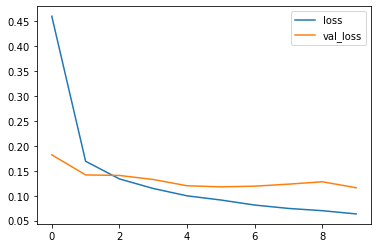

In [12]:
plt.plot(history.epoch,history.history.get('loss'),label = 'loss')
plt.plot(history.epoch,history.history.get('val_loss'),label = 'val_loss')
plt.legend()

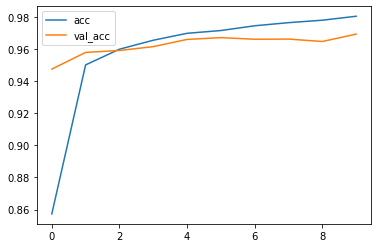

In [13]:
plt.plot(history.epoch,history.history.get('acc'),label = 'acc')
plt.plot(history.epoch,history.history.get('val_acc'),label = 'val_acc')
plt.legend()

# 对模型权重和偏置进行量化生成mif文件

In [14]:
import json
weight = model.get_weights()

In [15]:
# 将 浮点数 量化成定点数
def DtoB(num,dataWidth,fracBits):   #funtion for converting into two's complement format
    if num >= 0:
        num = num * (2**fracBits)
        num = int(num)
        d = num
    else:
        num = -num
        num = num * (2**fracBits)    #number of fractional bits
        num = int(num)
        if num == 0:
            d = 0
        else:
            d = 2**dataWidth - num
    return d

In [16]:
#定义数据位宽以及权重整数位宽和数据整数位宽
outputPath = "./w_b/"
weightIntWidth = 4
dataWidth = 16
dataIntWidth=1
dataFracWidth = dataWidth-dataIntWidth
weightFracWidth = dataWidth-weightIntWidth
biasIntWidth = dataIntWidth+weightIntWidth
biasFracWidth = dataWidth-biasIntWidth

In [17]:
#生成 权重的 mif 文件
for layer in range(0,len(weight)//2):
    for neuron in range(0,weight[2*layer].shape[1]):
        file = 'w_'+str(layer+1)+'_'+str(neuron)+'.mif'
        f = open(outputPath+file,'w')
        for i in range(0,len(weight[2*layer])):
            if 'e' in str(weight[2*layer][i][neuron]):
                w = '0'
            else:
                if(weight[2*layer][i][neuron] > 2**(weightIntWidth-1)):
                    weight[2*layer][i][neuron] = 2**(weightIntWidth-1)-2**(-weightFracWidth)
                elif(weight[2*layer][i][neuron] < -2**(weightIntWidth-1)):
                    weight[2*layer][i][neuron] = -2**(weightIntWidth-1)
                p = bin(DtoB(weight[2*layer][i][neuron],dataWidth,weightFracWidth))[2:]
            f.write(str(p)+'\n')
        f.close()

In [18]:
# 生成偏置的 mif 文件
for layer in range(0,len(weight)//2):
    for neuron in range(0,weight[2*layer+1].shape[0]):
        file = 'b_'+str(layer+1)+'_'+str(neuron)+'.mif'
        f = open(outputPath+file,'w')
        if 'e' in str(weight[2*layer+1][neuron]):
            w = '0'
        else:
            if(weight[2*layer+1][neuron] > 2**(weightIntWidth-1)):
                weight[2*layer+1][neuron] = 2**(weightIntWidth-1)-2**(-weightFracWidth)
            elif(weight[2*layer+1][neuron] < -2**(weightIntWidth-1)):
                weight[2*layer+1][neuron] = -2**(weightIntWidth-1)
            p = bin(DtoB(weight[2*layer+1][neuron],dataWidth,weightFracWidth))[2:]
        f.write(str(p)+'\n')
        f.close()

# 生成测试数据

## 前面784个数据为数据 最后一个数据表示其分类

In [19]:
testoutputPath = "./testData/"
dataWidth = 16                    
IntSize = 1 
fracWidth = dataWidth - IntSize

In [20]:
# 获取测试数据
for i in range(0,test_image_resize.shape[0]):   #获取所有数据使用  test_image_resize.shape[0]
    if i < 10:
        file_name = "000" + str(i)
    elif i < 100:
        file_name = "00" + str(i)
    elif i < 1000:
        file_name = "0" + str(i)
    else :
        file_name = str(i)
    file_name_final = 'test_data_' + file_name + '.txt'
    f = open(testoutputPath + file_name_final ,'w')
    for j in range(0,test_image_resize[i].shape[0]):
        dInDec = DtoB(test_image_resize[i][j],dataWidth,fracWidth)
        myData = bin(dInDec)[2:]
        f.write(str(myData)+'\n')
    f.write(str(bin(DtoB(test_label[i],dataWidth,0))[2:])+'\n')
    f.close()